## Neural Networks and Deep Learning
***
**Second Homework by Luca Negri, Physics of Data**

# Homework 2: Unsupervised Deep Learning: Autoencoders

## Introduction

The scope of this homework is to create a functional Autoencoders and to explore its latent space. 

Autoencoders are a type of unsupervised learning framework, wich is comprised of two main stages:

+ An **Encoder**, wich will have a last layer of a set number of nodes, called the **Latent space**, wich should still encapsulate all of the relevant informations about the samples.
+ A **Decoder**, wich, starting from the latent space representation, will try to recreate the original sample.

Autoencoders are a powerful class of unsupervised learning algorithms, since they can be really flexible and adapted to all kinds of situations. The encoder could be used as a sort of lossy compression algorithm for the original samples, new artificial samples can be created by setting arbitrary values in this space, different data manipulation teqniques such as denoising and reconstruction... the applications can be really varied and in this notebook a few of these will be explored.

The structure of this notebook goes as follows:
+ Construction and hyperparameter optimization of an Autoencoder.
+ Utilizing the latent space of the encoder for a supervised learning task.
+ Exploration of the latent space, with TSNE and look at generatio of samples
+ Development of a Variational Autoencoder.

# Part 1: Basic Autoencoder

### Import of the needed modules

In [1]:
#basics
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#pytorch
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split

#others
import os
from tqdm import tqdm

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'


## Dataset
As the previous homework, the samples will be taken from the FashionMNIST dataset, wich contains 28x28 single channel (black and white) images of items of clothing. This samples are from 10 different classes, wich will be used in the supervised learning task. All of the imaes are in a PIL format.

Here are a few examples of the different images.

In [2]:
total_dataset = torchvision.datasets.FashionMNIST('../classifier_data', train=True, download=True)
test_dataset  = torchvision.datasets.FashionMNIST('../classifier_data', train=False, download=True)

C:\Users\luca3\Anaconda3\envs\tfl\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


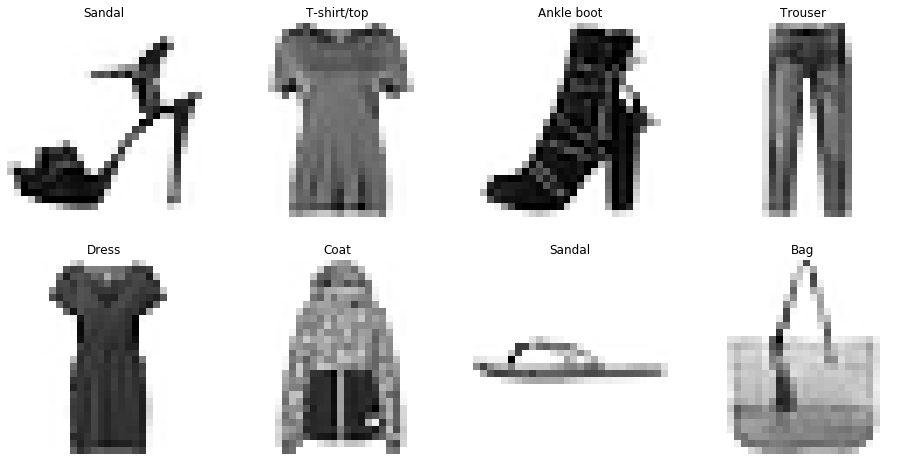

In [3]:
classes = total_dataset.classes
fig = plt.figure(figsize=(16,8))
for sample_index,nplot in zip([9,10,11,16,20,22,30,35],range(241,249)):
    image = total_dataset[sample_index][0]
    label = total_dataset[sample_index][1]
    fig.add_subplot(nplot)
    plt.imshow(image, cmap='Greys')#,vmax = 255)
    plt.title(classes[label])
    plt.axis('off')
plt.show()

## Transforms

The dataset needs to be a pytorch tensor in order for it to be handled by the network, so a transorms needs to be defined.

To help the network to be more reliable and avoid overfitting a random white noise is added to the images each time these are called. Here the standard deviation is set to 0.2 in order for the noise to not overcome the signal.

In [4]:
class WhiteNoise():
    """Class aimed at transforming a dataset adding random gaussian noise to the input variables"""
    def __init__(self, mu = 0.0 , std = 1.0):
        self.mu  = mu
        self.std = std
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mu
    
    
WNoiseTransform = WhiteNoise( std = 0.2)

train_transforms = transforms.Compose([
    transforms.ToTensor(),
    WNoiseTransform,
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
])

As it is common with these tasks the validation set is kept at 20 % of the total data, with the split handled by the pytorch function `data.random_split`.

In [5]:
val_split = 0.2

Ntot   = len(total_dataset)
Nval   = int(Ntot * val_split)
Ntrain = Ntot - Nval

train_dataset, val_dataset = torch.utils.data.random_split(total_dataset, [Ntrain, Nval])


test_dataset.transform  = test_transforms
val_dataset.dataset.transform   = test_transforms
train_dataset.dataset.transform = test_transforms

num_workers = 0 #PC
#num_workers = 2 #####COLAB ENABLED
batch_size = 512
train_dataloader = DataLoader(train_dataset , batch_size = batch_size        , shuffle = True  , num_workers=num_workers)
val_dataloader   = DataLoader(val_dataset   , batch_size = len(val_dataset)  , shuffle = True  , num_workers=num_workers)
test_dataloader  = DataLoader(test_dataset  , batch_size = len(test_dataset) , shuffle = False , num_workers=num_workers)

In [6]:
test_dataset[0][0].shape

torch.Size([1, 28, 28])

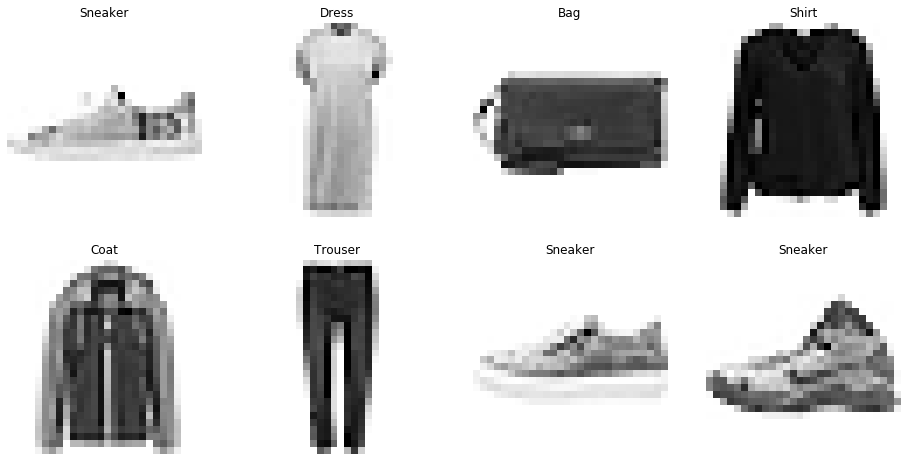

In [7]:
fig = plt.figure(figsize=(16,8))
for sample_index,nplot in zip([9,10,11,16,20,22,30,35],range(241,249)):
    image = train_dataset[sample_index][0].squeeze(0)
    label = train_dataset[sample_index][1]
    fig.add_subplot(nplot)
    plt.imshow(image, cmap='Greys',vmax=1)
    plt.title(classes[label])
    plt.axis('off')
plt.show()

## Network architecture

Since we are dealing with images a **Convolutional Autoencoder** has been chosen as the architecture of choice.

Even if it's possible to create asimmetrical networks, for this application a **Symmetrical** Encoder and decoder architecture has been chosen. So the description of the two networks, even if working indipendently, are totally similar

### Encoder
The Encoder is structured as follows:

+ An input layer from the images, wich must be 28x28 in size
+ A first convolutional layer, with $N_{ch1}$ channels and $K_1$ as the kernel size. The Final value for these  variables will be the objective of the random search. The stride is kept at 2 and a padding of 1 is added.
+ A second convolutional layer with $N_{ch2}$ channels and $K_2$ as the kernel size. Again the stride is kept at 2 and the padding at 1
+ A third convolutional layer with $N_{ch3}$ channles and $K_3$ as the kernel size. Stride is still at 2 but no padding is used in this last stage.
+ After flattening the channles of the third convolutional layer, the output is fed to a Fully Connected Layer with $N_h$ nodes.
+ A final output layer that directly gives out the values of the latent space representation of the sample

For all of the layers, except the last, the activation function is the standard ReLU function. The inizialization sheme chosen is the **Xavier normal**. The possibility of adding dropout to avopid overfiting is also added to the class. 


In [8]:
def init_weights(m):
    """Function to initialize weights in a layer"""
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        
        # gain is a parameter to be given to the xavier normal to decide the std, depends on the activation
        torch.nn.init.xavier_normal_(m.weight , torch.nn.init.calculate_gain( 'relu' ) )
        m.bias.data.fill_(0.01)

In [9]:
class Encoder(nn.Module):
    
    def __init__(self, InputShape, CH1 , Ksize1 , CH2 , Ksize2 , CH3 , Ksize3,
                 FCL,  encoded_space_dim,pDropout=0.0, init_func=init_weights):
        super().__init__()
        
        ### Convolutional section
        self.EncoderCNN = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(in_channels=1, out_channels=CH1, kernel_size=Ksize1, 
                      stride=2, padding=1),
            torch.nn.Dropout(pDropout),
            nn.ReLU(True),
            # Second convolutional layer
            nn.Conv2d(in_channels=CH1, out_channels=CH2, kernel_size=Ksize2, 
                      stride=2, padding=1),
            torch.nn.Dropout(pDropout),
            nn.ReLU(True),
            # Third convolutional layer
            nn.Conv2d(in_channels=CH2, out_channels=CH3, kernel_size=Ksize3, 
                      stride=2, padding=0),
            torch.nn.Dropout(pDropout),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
        
        # Ugly hack to calculate the shape of the output of the convolutional layer
        dummy_sample_image = torch.zeros(InputShape)
        self.FinalConvShape = self.EncoderCNN(dummy_sample_image).shape
        self.FlatConvSize  = np.prod(self.FinalConvShape)

        ### Linear section
        self.EncoderLin = nn.Sequential(
            # First linear layer
            nn.Linear(in_features=self.FlatConvSize, out_features=FCL),
            torch.nn.Dropout(pDropout),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(in_features=FCL, out_features=encoded_space_dim)
        )
        
        
        self.EncoderCNN.apply(init_func)
        self.EncoderLin.apply(init_func)
        
    def forward(self, x):
        # Apply convolutions
        x = self.EncoderCNN(x)
        # Flatten
        x = self.flatten(x)
        # # Apply linear layers
        x = self.EncoderLin(x)
        return x

### Decoder

The decoder has a basically completly specular structure with respect to the Encoder. 


+ An input layer that takes in the values of the latent space representating the original sample
+ A Fully Connected Layer with $N_h$ nodes.
+ A first transposed convolution, that takes as input the Deconvolved output of the FCL of $N_{ch3}$ channels and transposes it to $N_{ch2}$ channels
+ A second transposed convolution, that reduces the input to $N_{ch1}$ channels
+ A third and final transposed convolution that should give as output a 28x28 single channel image, representing the reconstruction of the original sample.

Again, as the encoder, the activation function is the ReLU, the inizialization scheme chosen is the Xavier normal, the user also has the possibility to add the dropout to facilitate training.


In [10]:
class Decoder(nn.Module):
    
    def __init__(self,FinalConvShape, CH1 , Ksize1 , CH2 , Ksize2 , CH3 , Ksize3,
                 FCL,  encoded_space_dim,pDropout=0.0, init_func=init_weights):
        super().__init__()
        
        FlatConvSize  = np.prod(FinalConvShape)

        ### Linear section
        self.decoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(in_features=encoded_space_dim, out_features=FCL),
            nn.ReLU(True),
            torch.nn.Dropout(pDropout),
            # Second linear layer
            nn.Linear(in_features=FCL, out_features=FlatConvSize),
            nn.ReLU(True)
        )

        ### Unflatten
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=FinalConvShape)

        ### Convolutional section
        self.decoder_conv = nn.Sequential(
            # First transposed convolution
            nn.ConvTranspose2d(in_channels=CH3, out_channels=CH2, kernel_size=Ksize3, 
                               stride=2, output_padding=0),
            torch.nn.Dropout(pDropout),
            nn.ReLU(True),
            # Second transposed convolution
            nn.ConvTranspose2d(in_channels=CH2, out_channels=CH1, kernel_size=Ksize2, 
                               stride=2, padding=1, output_padding=1),
            torch.nn.Dropout(pDropout),
            nn.ReLU(True),
            # Third transposed convolution
            nn.ConvTranspose2d(in_channels=CH1, out_channels=1, kernel_size=Ksize1, 
                               stride=2, padding=1, output_padding=1)
        )
        
        self.decoder_conv.apply(init_func)
        self.decoder_lin.apply(init_func)
        
    def forward(self, x):
        # Apply linear layers
        x = self.decoder_lin(x)
        # Unflatten
        x = self.unflatten(x)
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        # Apply a sigmoid to force the output to be between 0 and 1 (valid pixel values)
        x = torch.sigmoid(x)
        return x

Here there is a trial to see if the network is working as expected. A kernel window of 3x3 for $K_1$,$K_2$ and $K_3$. The FCL has $N_h$set to 64 nodes. $N_{ch1}$ is set to 8, and the following layers's $N_{ch2}$, $N_{ch3}$ are set to double each step. This trend will be kept in the search for the best hyperparameters.

In the image below it is possible to see the decoded sample. Since the network has not yet been trained it will look totally random.

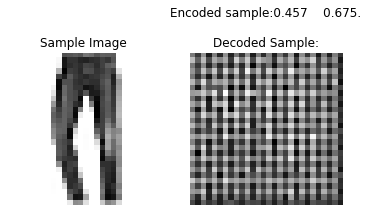

In [13]:
InputShape = (1,1,28,28)


CH1,CH2,CH3 = 8 , 16 , 32
Ksize1,Ksize2,Ksize3 = [(3,3)]*3
FCL = 64

encoded_space_dim = 10
EncoderNet = Encoder(InputShape,CH1,Ksize1,CH2,Ksize2,CH3,Ksize3,FCL,encoded_space_dim)
# Variable that tells the decoder the correct size of the last layer of the FCL part.
FinalConvShape = EncoderNet.FinalConvShape[1:]

DecoderNet = Decoder(FinalConvShape , CH1 , Ksize1 , CH2 , Ksize2 , CH3 , Ksize3 , FCL , encoded_space_dim)

image = test_dataset[5][0]
encoded_sample = EncoderNet(image.unsqueeze(0))

plt.subplot(1,2,1)
plt.title('Sample Image')
plt.imshow(image.squeeze(0) , cmap='Greys')
plt.axis('off')
plt.subplot(1,2,2)
plt.title(f'Encoded sample:{encoded_sample[0][0]:.3f}    {encoded_sample[0][1]:.3f}.\n\nDecoded Sample:' )
plt.imshow(DecoderNet(encoded_sample).squeeze(0).squeeze(0).detach().numpy(),cmap='Greys')
plt.axis('off')
plt.show()

In [18]:
DecoderNet(encoded_sample).shape

torch.Size([1, 1, 28, 28])

## Test Training

Here we define the functions needed for the training of the network.


+ `train_epoch` makes a single pass over all of the training data and updates the weights of both the encoder and the decoder trought backpropagation of the gradient over the loss funcion `loss_fn` and optimizes it with the given user defined `optimizer`.
+ `test_epoch` just evaluates the performance of the network over a specific dataset, giving as output the calculated loss, the real and the predicted labels of the given samples.
+ `train_func` automates the train and evaluation steps for a given number of epochs, giving as output the trained network and the loss over the epochs for both the train and valdation set.




In [19]:
def train_epoch(encoder,decoder,device, dataloader, loss_fn, optimizer,unsupervised = True, kl = 0, verbose=0, disable_tqdm=True):
    """Function to advance training one step"""
    # Set train mode
    encoder.train()
    decoder.train()
 
    for train_batch, label_batch in tqdm(dataloader,position=0,leave=True,disable=disable_tqdm):
        # Move tensors to the selected device
        train_batch = train_batch.to(device)
        label_batch = label_batch.to(device)
        # Forward pass
        if unsupervised:
            label_batch = train_batch
        latentvar = encoder(train_batch)
        out       = decoder(latentvar)
        # Evaluate loss
        # check if kl is required to compute
        if kl:
            totkl = encoder.kl*kl
        # Evaluate loss
        loss = loss_fn(out, label_batch) + totkl
        # Backward pass and update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print loss
        if verbose==2:
            print('\t Training loss (single batch):', float(loss.data))
            
            
### Testing function
def test_epoch(encoder,decoder, device, dataloader, loss_fn ,unsupervised = True,kl = 0,disable_tqdm=True):
    # Set evaluation mode
    encoder.eval()
    decoder.eval
    with torch.no_grad():
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        totkl = 0
        for train_batch, label_batch in tqdm(dataloader,position=0,leave=True,disable=disable_tqdm):
            # Move tensor to the proper device
            train_batch = train_batch.to(device)
            label_batch = label_batch.to(device)
            # Forward pass
            if unsupervised:
                label_batch = train_batch
            
            latentvar = encoder(train_batch)
            out       = decoder(latentvar)    
            if kl:
                totkl += kl*encoder.kl
            # Append the network output and the original to the lists
            conc_out.append(out)
            conc_label.append(label_batch)
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label) + totkl
    return conc_out, conc_label, val_loss.data # We return all the outputs, all the labels and the global loss


def train_func(encoder,decoder, train_dataloader ,val_dataloader , device, loss_fn, optimizer,unsupervised = True, kl=0 ,verbose = 1, num_epochs=50, disable_tqdm=True ):
    ### TRAINING!

    train_losses = []
    val_losses = []
    
    tqdm_upper = True
    if verbose == 0 :
        tqdm_upper = False
        
    for epoch in tqdm(range(num_epochs),position=0,leave=True,disable=tqdm_upper):
        if verbose >= 1:
            print(f"EPOCH {epoch + 1}/{num_epochs}")
        ### Training 
        train_epoch(
            encoder,decoder,
            device=device, 
            dataloader=train_dataloader, 
            loss_fn=loss_fn, 
            optimizer=optimizer,
            unsupervised=unsupervised, kl=kl,
            verbose=verbose,
            disable_tqdm=disable_tqdm)

        ### Train loss 
        _, _, train_loss = test_epoch(
            encoder, decoder,
            device=device, 
            dataloader=train_dataloader, 
            loss_fn=loss_fn,
            unsupervised=unsupervised, kl=kl,
            disable_tqdm=disable_tqdm)

        # Print Train loss
        if verbose >=1:
            print(f"\n\n\t TRAIN - EPOCH {epoch + 1}/{num_epochs} - train loss: {train_loss}\n\n")
        train_losses.append(train_loss)

        ### Validation 
        _, _, val_loss = test_epoch(
            encoder,decoder,
            device=device, 
            dataloader=val_dataloader, 
            loss_fn=loss_fn,
            unsupervised=unsupervised, kl=kl,
            disable_tqdm=disable_tqdm)

        # Print Validation loss
        if verbose>=1:
            print(f"\n\n\t VALIDATION - EPOCH {epoch + 1}/{num_epochs} - val loss: {val_loss}\n\n")
        val_losses.append(val_loss)
        
    return train_losses, val_losses

In the cell below a test training is done, with some provisional hyperparameter choice.

The loss function chosen for this task is the **Mean squared error** since it will indicate to the optimizer how much each pixel of the decoded image is off with respect to the original sample.

The latent space is kept at 10 dimensions. trying somehow to capture the fact that the samples are coming from 10 different classes.

In [20]:
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr = 2e-3 # Learning rate
params_to_optimize = [
    {'params': EncoderNet.parameters()},
    {'params': DecoderNet.parameters()}
]
optimizer = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-5)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')




Selected device: cpu


In [193]:
train_losses, val_losses = train_func(EncoderNet,DecoderNet, train_dataloader , val_dataloader,
                                     device, loss_fn, optimizer, verbose = 0,
                                      num_epochs  = 10)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:48<00:00, 22.82s/it]


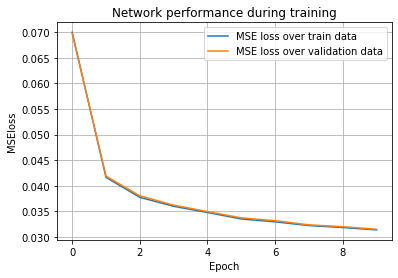

In [194]:
plt.plot(train_losses, label = 'MSE loss over train data')
plt.plot(val_losses, label = 'MSE loss over validation data')
plt.xlabel('Epoch')
plt.ylabel('MSEloss')
plt.title('Network performance during training')
plt.legend()
plt.grid()
plt.show()

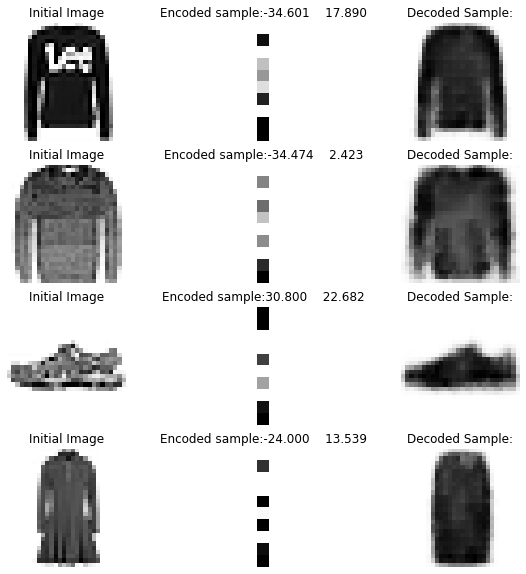

In [403]:
sample_idxs = [1,20,21,29]
plt.figure(figsize=[10,10])
n  = len(sample_idxs)
EncoderNet.eval()
DecoderNet.eval()
with torch.no_grad():
    for i,idx in enumerate(sample_idxs):
        image = test_dataset[idx][0]
        encoded_sample = EncoderNet(image.unsqueeze(0))


        plt.subplot(n,3,1+ i*3)
        plt.title('Initial Image')
        plt.imshow(image.squeeze(0) , cmap='Greys')
        plt.axis('off')

        plt.subplot(n,3,2+i*3)
        plt.title(f'Encoded sample:{encoded_sample[0][0]:.3f}    {encoded_sample[0][1]:.3f}')
        plt.imshow(encoded_sample.detach().numpy().T , cmap='Greys',vmin = -20,vmax=+20)
        plt.axis('off')

        plt.subplot(n,3,3+i*3)
        plt.title('Decoded Sample:' )
        plt.imshow(DecoderNet(encoded_sample).squeeze(0).squeeze(0).detach().numpy(),cmap='Greys')
        plt.axis('off')
plt.show()

## Hyperparametr optimization 
To validate the best parameters for the Autoencoder a Random seach is performed. Then in the end the network wil be finally trained with the best results coming from this search.

### Random Search

Random searches are a common tool for hyperparameters optimizaition in machine learning. They allow to not waste as much resources as gridsearches while still maintaining a good enought degree of good results with high dimensional searches.

The random search itself is performed by the function `RandomSearch2` and it will choose 10 random points in hyperparameter space and perform the training. To validate the results k-fold cross validation is used, where the dataset is divided into 4 parts, of these 3 will be used as training set and one as validation. Then the training is performed again, rotating each time wich of the 4 sets will be validation. Then a mean of the final losses is used to compare the hyperparameters results.

The hyperparameters that the search will try to optimnize are:

+ $N_{ch1}$ ($N_{ch2}$ and $N_{ch3}$ will be always kept as successive doublings of $N_{ch1}$)
+ $N_h$
+ Dropout probability
+ Optimizer (between Adam or Adamax)
+ Learning rate
+ Weight decay
+ The batch size 
+ The number of epochs

The results will be recorded in the not so originally named `results` pandas dataframe

In [342]:
def RandomSearch2(params_to_choose, EncCLass,DecClass, train_dataset, transform , n_folds = 4 , n_points = 5):
    """random search"""

    Ntot = len(train_dataset)
    Nval = int(Ntot/n_folds)
    cvs = torch.utils.data.random_split(train_dataset,[Nval]*n_folds)
    result_df_columns = ['mean_loss'] + list(params_to_choose.keys()) + ['losslog_cv' + str(i) for i in range(n_folds)] 

    results = pd.DataFrame(np.zeros((n_points,len(result_df_columns))),
                           columns = result_df_columns, dtype=object)
   

    for i in range(n_points):

        params   = {}
        for param in params_to_choose.keys():
            params[param] = np.random.choice(params_to_choose[param])

            results[param][i] = params[param]

        print('ITERATION N ' + str(i+1))
        print('PARAMS:\n' )
        for value,name in zip(params.values(),params.keys()):
            print(name,'     \t :',value)

        val_cv_losses = []

        mean_loss = 0

        for j in range(n_folds):

            train_cv = cvs.copy()
            val_cv   = train_cv.pop(j)
            train_cv = torch.utils.data.ConcatDataset(train_cv)

            train_cv.transform = transform
            val_cv.transform   = transform

            batch_size = int(params['batch_size'])
            train_dataloader = DataLoader(train_cv , batch_size= batch_size , shuffle=True  , num_workers=0)
            val_dataloader   = DataLoader(val_cv   , batch_size=len(val_cv) , shuffle=False , num_workers=0)  
            
            InputShape  = (1,1,28,28)
            encoded_dim = params['encoded_dim']

            
            CH1       = params['CH1']
            CH2,CH3   = CH1*2 , CH1*4
            Ksize1,Ksize2,Ksize3     = [(params['Ksize'],params['Ksize'])]*3
            
            FCL       = params['FCL']
            init_func = params['init_func']
            p_drop    = params['p_drop']
            encoder   = EncClass(InputShape,CH1,Ksize1,CH2,Ksize2,CH3,Ksize3,
                                FCL,encoded_dim,init_func=init_func,pDropout=p_drop)
            FinalConvShape = encoder.FinalConvShape[1:]
            decoder   = DecClass(FinalConvShape,CH1,Ksize1,CH2,Ksize2,CH3,Ksize3,
                                FCL,encoded_dim,p_drop,init_func)
            
            encoder.to(device)
            decoder.to(device)

            loss_fn = params['loss_fn']

            optimizer = params['optimizer']
            
            params_to_optimize = [
                {'params': encoder.parameters()},
                {'params': decoder.parameters()}
            ]
            optimizer = optimizer(params_to_optimize,lr=params['lr'] , weight_decay = params['w_decay'] )

            _ , val_loss_log = train_func(encoder,decoder,train_dataloader,val_dataloader,device,
                                          loss_fn, optimizer, verbose=0,
                                          num_epochs = params['num_epochs'], disable_tqdm=True)

            results['losslog_cv' + str(j) ][i] = val_loss_log
            mean_loss += val_loss_log[-1]     

        results['mean_loss'][i] = mean_loss/n_folds
    return results

In [343]:
params_to_choose = {
    'encoded_dim': [10],
    'CH1'        : [4 , 8],
    'Ksize'      : [3],
    'FCL'    : [64 , 128 , 256],
    'init_func'  : [init_weights],
    'p_drop'     : [0.2 , 0.3 , 0.4],
    'loss_fn'    : [nn.MSELoss()],
    'optimizer'  : [optim.Adam , optim.Adamax ],
    'w_decay'    : [0    , 1e-5 , 1e-4],
    'lr'         : [5e-4 , 1e-3 , 2e-3],
    'batch_size' : [256  , 512  ,1024],
    'num_epochs' : [10 , 15]
}

In [322]:
Ntot = len(train_dataset)
NSmall = int(Ntot/4)
small_train_dataset , _ = torch.utils.data.random_split(train_dataset , [ NSmall , Ntot - NSmall ])

In [323]:
results = RandomSearch2(params_to_choose,Encoder,Decoder,small_train_dataset,train_transforms,n_points=10)

ITERATION N 1
PARAMS:

encoded_dim      	 : 10
CH1      	 : 4
Ksize      	 : 3
FCL      	 : 128
init_func      	 : <function init_weights at 0x00000182C5771C80>
p_drop      	 : 0.4
loss_fn      	 : MSELoss()
optimizer      	 : <class 'torch.optim.adam.Adam'>
w_decay      	 : 0.0
lr      	 : 0.001
batch_size      	 : 1024
num_epochs      	 : 15


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [01:06<00:00,  4.44s/it]


ITERATION N 2
PARAMS:

encoded_dim      	 : 10
CH1      	 : 8
Ksize      	 : 3
FCL      	 : 64
init_func      	 : <function init_weights at 0x00000182C5771C80>
p_drop      	 : 0.2
loss_fn      	 : MSELoss()
optimizer      	 : <class 'torch.optim.adamax.Adamax'>
w_decay      	 : 0.0
lr      	 : 0.002
batch_size      	 : 256
num_epochs      	 : 10


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:51<00:00,  5.20s/it]


ITERATION N 3
PARAMS:

encoded_dim      	 : 10
CH1      	 : 4
Ksize      	 : 3
FCL      	 : 128
init_func      	 : <function init_weights at 0x00000182C5771C80>
p_drop      	 : 0.4
loss_fn      	 : MSELoss()
optimizer      	 : <class 'torch.optim.adamax.Adamax'>
w_decay      	 : 0.0001
lr      	 : 0.0005
batch_size      	 : 256
num_epochs      	 : 15


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [01:02<00:00,  4.17s/it]


ITERATION N 4
PARAMS:

encoded_dim      	 : 10
CH1      	 : 8
Ksize      	 : 3
FCL      	 : 256
init_func      	 : <function init_weights at 0x00000182C5771C80>
p_drop      	 : 0.4
loss_fn      	 : MSELoss()
optimizer      	 : <class 'torch.optim.adam.Adam'>
w_decay      	 : 0.0001
lr      	 : 0.0005
batch_size      	 : 256
num_epochs      	 : 15


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [01:26<00:00,  5.80s/it]


ITERATION N 5
PARAMS:

encoded_dim      	 : 10
CH1      	 : 8
Ksize      	 : 3
FCL      	 : 64
init_func      	 : <function init_weights at 0x00000182C5771C80>
p_drop      	 : 0.3
loss_fn      	 : MSELoss()
optimizer      	 : <class 'torch.optim.adam.Adam'>
w_decay      	 : 0.0001
lr      	 : 0.002
batch_size      	 : 512
num_epochs      	 : 10


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:57<00:00,  5.79s/it]


ITERATION N 6
PARAMS:

encoded_dim      	 : 10
CH1      	 : 8
Ksize      	 : 3
FCL      	 : 64
init_func      	 : <function init_weights at 0x00000182C5771C80>
p_drop      	 : 0.4
loss_fn      	 : MSELoss()
optimizer      	 : <class 'torch.optim.adam.Adam'>
w_decay      	 : 0.0001
lr      	 : 0.001
batch_size      	 : 512
num_epochs      	 : 10


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:55<00:00,  5.51s/it]


ITERATION N 7
PARAMS:

encoded_dim      	 : 10
CH1      	 : 4
Ksize      	 : 3
FCL      	 : 128
init_func      	 : <function init_weights at 0x00000182C5771C80>
p_drop      	 : 0.2
loss_fn      	 : MSELoss()
optimizer      	 : <class 'torch.optim.adam.Adam'>
w_decay      	 : 0.0001
lr      	 : 0.002
batch_size      	 : 512
num_epochs      	 : 15


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [01:05<00:00,  4.34s/it]


ITERATION N 8
PARAMS:

encoded_dim      	 : 10
CH1      	 : 4
Ksize      	 : 3
FCL      	 : 128
init_func      	 : <function init_weights at 0x00000182C5771C80>
p_drop      	 : 0.2
loss_fn      	 : MSELoss()
optimizer      	 : <class 'torch.optim.adam.Adam'>
w_decay      	 : 1e-05
lr      	 : 0.0005
batch_size      	 : 256
num_epochs      	 : 10


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:44<00:00,  4.46s/it]


ITERATION N 9
PARAMS:

encoded_dim      	 : 10
CH1      	 : 4
Ksize      	 : 3
FCL      	 : 128
init_func      	 : <function init_weights at 0x00000182C5771C80>
p_drop      	 : 0.4
loss_fn      	 : MSELoss()
optimizer      	 : <class 'torch.optim.adam.Adam'>
w_decay      	 : 0.0
lr      	 : 0.002
batch_size      	 : 512
num_epochs      	 : 15


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [01:08<00:00,  4.55s/it]


ITERATION N 10
PARAMS:

encoded_dim      	 : 10
CH1      	 : 4
Ksize      	 : 3
FCL      	 : 128
init_func      	 : <function init_weights at 0x00000182C5771C80>
p_drop      	 : 0.4
loss_fn      	 : MSELoss()
optimizer      	 : <class 'torch.optim.adamax.Adamax'>
w_decay      	 : 1e-05
lr      	 : 0.002
batch_size      	 : 1024
num_epochs      	 : 10


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:46<00:00,  4.65s/it]


In [324]:
results

,mean_loss,encoded_dim,CH1,Ksize,FCL,init_func,p_drop,loss_fn,optimizer,w_decay,lr,batch_size,num_epochs,losslog_cv0,losslog_cv1,losslog_cv2,losslog_cv3
0,tensor(0.0858),10,4,3,128,<function init_weights at 0x00000182C5771C80>,0.4,MSELoss(),<class 'torch.optim.adam.Adam'>,0,0.001,1024,15,"[tensor(0.1445), tensor(0.1404), tensor(0.1345...","[tensor(0.1731), tensor(0.1639), tensor(0.1529...","[tensor(0.1429), tensor(0.1408), tensor(0.1364...","[tensor(0.1476), tensor(0.1467), tensor(0.1458..."
1,tensor(0.0489),10,8,3,64,<function init_weights at 0x00000182C5771C80>,0.2,MSELoss(),<class 'torch.optim.adamax.Adamax'>,0,0.002,256,10,"[tensor(0.1305), tensor(0.1028), tensor(0.0752...","[tensor(0.1245), tensor(0.0927), tensor(0.0734...","[tensor(0.1481), tensor(0.1037), tensor(0.0900...","[tensor(0.1313), tensor(0.0966), tensor(0.0765..."
2,tensor(0.1024),10,4,3,128,<function init_weights at 0x00000182C5771C80>,0.4,MSELoss(),<class 'torch.optim.adamax.Adamax'>,0.0001,0.0005,256,15,"[tensor(0.1659), tensor(0.1625), tensor(0.1565...","[tensor(0.1424), tensor(0.1387), tensor(0.1330...","[tensor(0.1786), tensor(0.1757), tensor(0.1722...","[tensor(0.1674), tensor(0.1642), tensor(0.1607..."
3,tensor(0.0548),10,8,3,256,<function init_weights at 0x00000182C5771C80>,0.4,MSELoss(),<class 'torch.optim.adam.Adam'>,0.0001,0.0005,256,15,"[tensor(0.2107), tensor(0.1979), tensor(0.1647...","[tensor(0.1795), tensor(0.1534), tensor(0.1279...","[tensor(0.1862), tensor(0.1333), tensor(0.1106...","[tensor(0.1556), tensor(0.1182), tensor(0.1035..."
4,tensor(0.0518),10,8,3,64,<function init_weights at 0x00000182C5771C80>,0.3,MSELoss(),<class 'torch.optim.adam.Adam'>,0.0001,0.002,512,10,"[tensor(0.1364), tensor(0.1036), tensor(0.0926...","[tensor(0.1349), tensor(0.1097), tensor(0.0963...","[tensor(0.1702), tensor(0.1112), tensor(0.0950...","[tensor(0.1463), tensor(0.1019), tensor(0.0926..."
5,tensor(0.0720),10,8,3,64,<function init_weights at 0x00000182C5771C80>,0.4,MSELoss(),<class 'torch.optim.adam.Adam'>,0.0001,0.001,512,10,"[tensor(0.1511), tensor(0.1480), tensor(0.1364...","[tensor(0.1396), tensor(0.1323), tensor(0.1134...","[tensor(0.1458), tensor(0.1421), tensor(0.1251...","[tensor(0.1685), tensor(0.1309), tensor(0.1078..."
6,tensor(0.0532),10,4,3,128,<function init_weights at 0x00000182C5771C80>,0.2,MSELoss(),<class 'torch.optim.adam.Adam'>,0.0001,0.002,512,15,"[tensor(0.1671), tensor(0.1621), tensor(0.1536...","[tensor(0.1844), tensor(0.1709), tensor(0.1236...","[tensor(0.1451), tensor(0.1376), tensor(0.1078...","[tensor(0.1580), tensor(0.1548), tensor(0.1492..."
7,tensor(0.0721),10,4,3,128,<function init_weights at 0x00000182C5771C80>,0.2,MSELoss(),<class 'torch.optim.adam.Adam'>,1e-05,0.0005,256,10,"[tensor(0.1515), tensor(0.1258), tensor(0.1072...","[tensor(0.1813), tensor(0.1790), tensor(0.1765...","[tensor(0.2076), tensor(0.1788), tensor(0.1372...","[tensor(0.1934), tensor(0.1900), tensor(0.1872..."
8,tensor(0.0699),10,4,3,128,<function init_weights at 0x00000182C5771C80>,0.4,MSELoss(),<class 'torch.optim.adam.Adam'>,0,0.002,512,15,"[tensor(0.1420), tensor(0.1111), tensor(0.0975...","[tensor(0.1391), tensor(0.1130), tensor(0.1031...","[tensor(0.1303), tensor(0.1100), tensor(0.0951...","[tensor(0.1558), tensor(0.1489), tensor(0.1398..."
9,tensor(0.1115),10,4,3,128,<function init_weights at 0x00000182C5771C80>,0.4,MSELoss(),<class 'torch.optim.adamax.Adamax'>,1e-05,0.002,1024,10,"[tensor(0.1423), tensor(0.1372), tensor(0.1320...","[tensor(0.1479), tensor(0.1464), tensor(0.1449...","[tensor(0.1679), tensor(0.1636), tensor(0.1580...","[tensor(0.1788), tensor(0.1604), tensor(0.1441..."


## Training with the best results of the random search

Here the best results coming out of the random search are presented. As we can see a value of 8 is chosen for $N_{ch1}$ a value of 64 is chosen for $N_h$. dropout is kept at 0.2, learning rate at 2e-3, batch size of 256 and no weight decay.

In [326]:
best_results = results.loc[results.mean_loss.apply(float).idxmin()]
best_results

mean_loss                                         tensor(0.0489)
encoded_dim                                                   10
CH1                                                            8
Ksize                                                          3
FCL                                                           64
init_func          <function init_weights at 0x00000182C5771C80>
p_drop                                                       0.2
loss_fn                                                MSELoss()
optimizer                    <class 'torch.optim.adamax.Adamax'>
w_decay                                                        0
lr                                                         0.002
batch_size                                                   256
num_epochs                                                    10
losslog_cv0    [tensor(0.1305), tensor(0.1028), tensor(0.0752...
losslog_cv1    [tensor(0.1245), tensor(0.0927), tensor(0.0734...
losslog_cv2    [tensor(0.

In [369]:
batch_size = best_results.batch_size
train_dataloader = DataLoader(train_dataset , batch_size=int(batch_size)  , shuffle=True  , num_workers=0)
val_dataloader   = DataLoader(val_dataset   , batch_size=len(val_dataset) , shuffle=False , num_workers=0)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")


torch.manual_seed(0)
Input_shape = (28,28)
encoded_dim = 10
CH1         = best_results.CH1
CH2,CH3     = CH1*2 , CH1*4
Ksize1,Ksize2,Ksize3     = [(3,3)]*3
FCL   = best_results.FCL

EncoderNet = Encoder(InputShape,CH1,Ksize1,CH2,Ksize2,CH3,Ksize3,FCL,encoded_dim)
FinalConvShape = EncoderNet.FinalConvShape[1:]
DecoderNet = Decoder(FinalConvShape , CH1 , Ksize1 , CH2 , Ksize2 , CH3 , Ksize3 , FCL , encoded_dim)


params_to_optimize = [
    {'params': EncoderNet.parameters()},
    {'params': DecoderNet.parameters()}
]


optimizer = best_results.optimizer(params_to_optimize, lr=best_results.lr
                                   ,weight_decay=best_results.w_decay)
loss_fn = nn.MSELoss()

train_losses, val_losses = train_func(EncoderNet,DecoderNet, train_dataloader , val_dataloader,
                                     device, loss_fn, optimizer, verbose = 0,
                                      num_epochs  = best_results.num_epochs)

Training device: cpu


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [04:06<00:00, 24.70s/it]


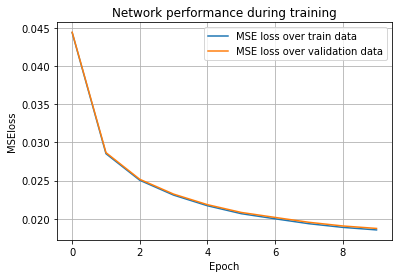

In [372]:
plt.plot(train_losses, label = 'MSE loss over train data')
plt.plot(val_losses, label = 'MSE loss over validation data')
plt.xlabel('Epoch')
plt.ylabel('MSEloss')
plt.title('Network performance during training')
plt.legend()
plt.grid()
plt.show()

As we can see the trainign goes on pretty smoothly, with the reconstruction loss of the training set kept basically equal to the valiudation set, meaning that overefitting does not play a huge role in the network training.

In [418]:
torch.save(EncoderNet.state_dict(), 'encoder_params.pth')
torch.save(DecoderNet.state_dict(), 'decoder_params.pth')

## Test the performance of the network

Our next step is to visually inspect the performance of the network, in particular now the objective is to focus on how many features and how accuratly the decoded samples reconstruct their original counterparts.

In [14]:
EncoderNet.load_state_dict(torch.load('encoder_params.pth'))
DecoderNet.load_state_dict(torch.load('decoder_params.pth'))

<All keys matched successfully>

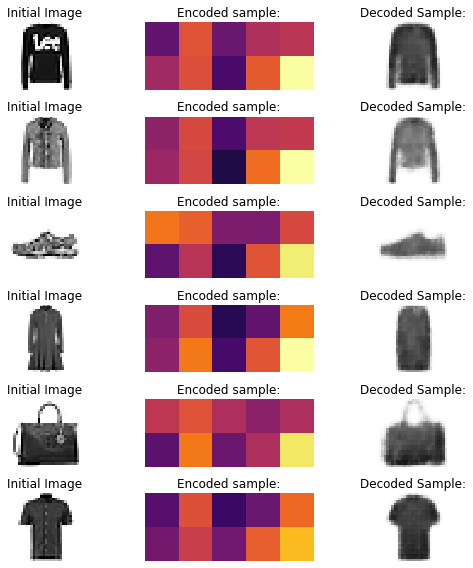

In [27]:
sample_idxs = [1,10,21,29,30,40]
plt.figure(figsize=[8,8])
n  = len(sample_idxs)

EncoderNet.eval()
DecoderNet.eval()
with torch.no_grad():
    for i,idx in enumerate(sample_idxs):

        image = test_dataset[idx][0]
        encoded_sample = EncoderNet(image.unsqueeze(0))

        plt.subplot(n,3,1+ i*3)
        plt.title('Initial Image')
        plt.imshow(image.squeeze(0) , cmap='Greys',vmin=0,vmax=1)
        plt.axis('off')

        plt.subplot(n,3,2+i*3)
        plt.title(f'Encoded sample:')
        plt.imshow(encoded_sample.detach().numpy().reshape(2,5) , cmap='inferno',vmin = -80,vmax=+80)
        #plt.imshow(encoded_sample.detach().numpy().reshape(2,5) , cmap='Greys')#,vmin = -34,vmax=+34)
        plt.axis('off')

        plt.subplot(n,3,3+i*3)
        plt.title('Decoded Sample:' )
        plt.imshow(DecoderNet(encoded_sample).squeeze(0).squeeze(0).detach().numpy(),cmap='Greys',vmin = 0,vmax = 1)
        plt.axis('off')
plt.tight_layout()
plt.show()

The main morphology of the samples is maintained in all of the test here performed. In particular the main features that  make i tpossible to distinguish between the different classes of clothing are maintained, with maybe an exception for the dress, where the sleeves are totally removed. Of course all of the details of the clothing get lost in the compression, making them appear like badly focused version of them. other fine details, like the bag handle, or the sole of the shoe get badly reconstructed. 

### Image Denoising

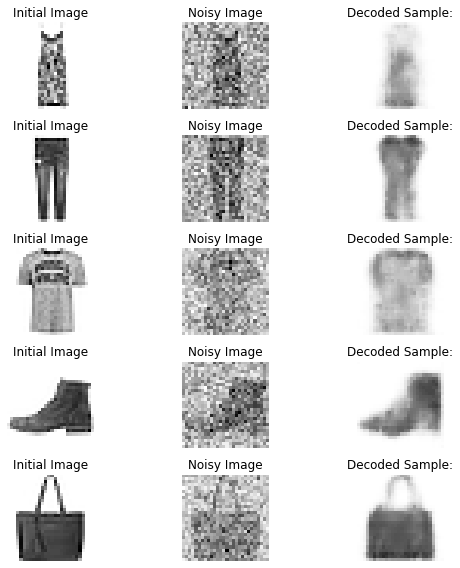

In [29]:
noise_func = WhiteNoise( std = 0.4)
sample_idxs = [300,200,201,208,900]
n  = len(sample_idxs)
plt.figure(figsize=[8,8])


EncoderNet.eval()
DecoderNet.eval()
with torch.no_grad():

    for i,idx in enumerate(sample_idxs):

        image = test_dataset[idx][0]
        noisy_sample = noise_func(image)
        encoded_sample = EncoderNet(noisy_sample.unsqueeze(0))



        plt.subplot(n,3,1+ i*3)
        plt.title('Initial Image')
        plt.imshow(image.squeeze(0) , cmap='Greys',vmin=0,vmax=1)
        plt.axis('off')

        plt.subplot(n,3,2+i*3)
        plt.title('Noisy Image')
        plt.imshow(noisy_sample.squeeze(0) , cmap='Greys')
        plt.axis('off')

        plt.subplot(n,3,3+i*3)
        plt.title('Decoded Sample:' )
        plt.imshow(DecoderNet(encoded_sample).squeeze(0).squeeze(0).detach().numpy(),cmap='Greys',vmin=0,vmax=1)
        plt.axis('off')
    plt.tight_layout()
    plt.show()



### Image reconstruction

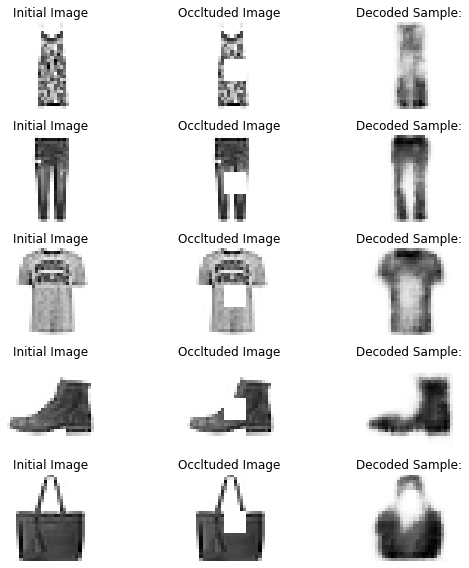

In [422]:
sample_idxs = [300,200,201,208,900]
n  = len(sample_idxs)

mask_size   = 7
mask_center = [12,12] 
mask = torch.ones_like(image)
mask[0,mask_center[0]:(mask_center[0])+mask_size , mask_center[1]:(mask_center[1])+mask_size] = 0
plt.figure(figsize=[8,8])

EncoderNet.eval()
DecoderNet.eval()
with torch.no_grad():

    for i,idx in enumerate(sample_idxs):

        image = test_dataset[idx][0]
        noisy_sample = image*mask
        encoded_sample = EncoderNet(noisy_sample.unsqueeze(0))



        plt.subplot(n,3,1+ i*3)
        plt.title('Initial Image')
        plt.imshow(image.squeeze(0) , cmap='Greys')
        plt.axis('off')

        plt.subplot(n,3,2+i*3)
        plt.title('Occltuded Image')
        plt.imshow(noisy_sample.squeeze(0) , cmap='Greys')
        plt.axis('off')

        plt.subplot(n,3,3+i*3)
        plt.title('Decoded Sample:' )
        plt.imshow(DecoderNet(encoded_sample).squeeze(0).squeeze(0).detach().numpy(),cmap='Greys')
        plt.axis('off')

    plt.tight_layout()    
    plt.show()

# Fine-tuned in supervised learning task

In [423]:
class FCLNet(nn.Module):
    
    """Network class, contains 3 hidden layers"""
    
    def __init__(self, InputSize,  No, FCLSize = [128,128], 
                 pDropout=0.0, init_func=init_weights):
        """
        Args:
        InputSize (tuple)                 : Input size of the encoded space
        No (int)                          : Output size
        FCLSize (int)                     : Fully connected Layer Size
        pDropout (float [0,1] )           : Probability of dropout
        init_func (nn.init function)      : Function to be applied to inizialize Tensors 
        """
        super().__init__()
        
        print('Network initialized')
        
        #FC passage
        self.FCLayer = torch.nn.Sequential(
            
            torch.nn.Linear(InputSize,FCLSize[0]),
            torch.nn.Dropout(pDropout),
            torch.nn.ReLU(True),
            
            torch.nn.Linear(FCLSize[0],FCLSize[1]),
            torch.nn.Dropout(pDropout),
            torch.nn.ReLU(True),

            #Output Layer
            torch.nn.Linear(FCLSize[1],No)
            
        )
        
        #Inizialization
        self.FCLayer.apply(init_func)

        
    def forward(self, x):
        x = self.FCLayer(x)
        return x

In [425]:
No = 10
FCLSize = [128,128]
FineTuneNet = FCLNet(encoded_dim,No,FCLSize,pDropout = 0.3)

loss_fn = torch.nn.CrossEntropyLoss()
### Define an optimizer (both for the encoder and the decoder!)
lr = 2e-3 # Learning rate
optimizer = torch.optim.Adam(FineTuneNet.parameters(), lr=lr, weight_decay=1e-5)

train_losses, val_losses = train_func(EncoderNet,FineTuneNet, train_dataloader , val_dataloader,
                                     device, loss_fn, optimizer, verbose = 0,
                                      unsupervised  = False,
                                      num_epochs  =10)

Network initialized


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [02:56<00:00, 17.66s/it]


In [514]:
# plt.plot(train_losses, label = 'cross entropy loss over train data')
# plt.plot(val_losses, label = 'cross entropy loss over validation data')
# plt.xlabel('Epoch')
# plt.ylabel('CrossEloss')
# plt.title('Network performance during training')
# plt.legend() 
# plt.grid()
# plt.show()

In [428]:
sm = torch.nn.Softmax(dim=1)

val_out, val_labels , valloss = test_epoch(EncoderNet,FineTuneNet,device,test_dataloader,loss_fn,unsupervised = False)
val_out        = np.array(sm(val_out))
val_out_labels = np.argmax(val_out,axis=1)
val_acc = 100*(sum(np.array(val_labels)==val_out_labels))/val_out_labels.shape
classes = test_dataset.classes
NClass = len(classes)
Conf_matrix = np.zeros([ NClass , NClass ])
for i in np.arange(val_out_labels.size):
    Conf_matrix[ val_labels[i] , val_out_labels[i] ] += 1
_, n_of_labels = np.unique(val_labels, return_counts = True)
Conf_matrix = Conf_matrix.T/Conf_matrix.T.sum(axis=0)
Conf_matrix = Conf_matrix.T

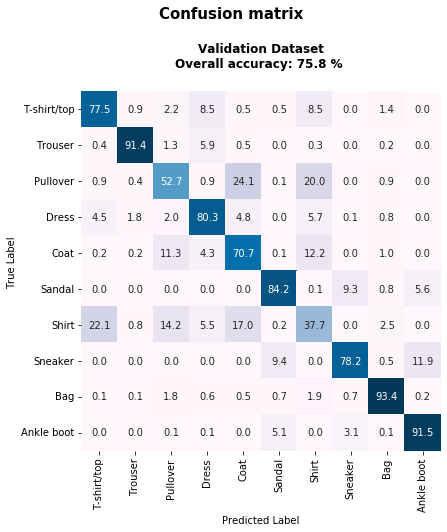

In [429]:
import seaborn as sns
fig,ax=plt.subplots(figsize=[7,7])
plt.suptitle('Confusion matrix',y=1.05,fontsize=15,weight='bold')



df_Confusion = pd.DataFrame( Conf_matrix*100 ,classes,classes)



sns.heatmap(df_Confusion, ax = ax, cmap = 'PuBu', square = True, annot = True , fmt = '.1f', 
            cbar = False, cbar_kws = {"shrink": 0.56} )

ax.set_title('Validation' + f' Dataset\nOverall accuracy: {val_acc[0]:.1f} % ', fontweight='bold')
ax.set_ylabel('True Label')
ax.set_xlabel('Predicted Label')

ax.set_ylim(10,-0.5, -0.5)
plt.tight_layout()
#plt.savefig('net_out.png')
plt.show()

# Exploration of the Latent space
## TSNE embedding

In [461]:
encoded_test  = []
labels = []
for image,label in test_dataloader:
    encoded_test.append(EncoderNet(image))
    labels.append(label)
labels=labels[0].detach()
encoded_test = encoded_test[0].detach()

In [487]:
from sklearn.manifold import TSNE


tsne         = TSNE(n_components=2,perplexity=40)
encoded_TSNE = tsne.fit_transform(encoded_test)

In [583]:
#np.save('TSNE_embedded_encoded_FMNIST', encoded_TSNE)

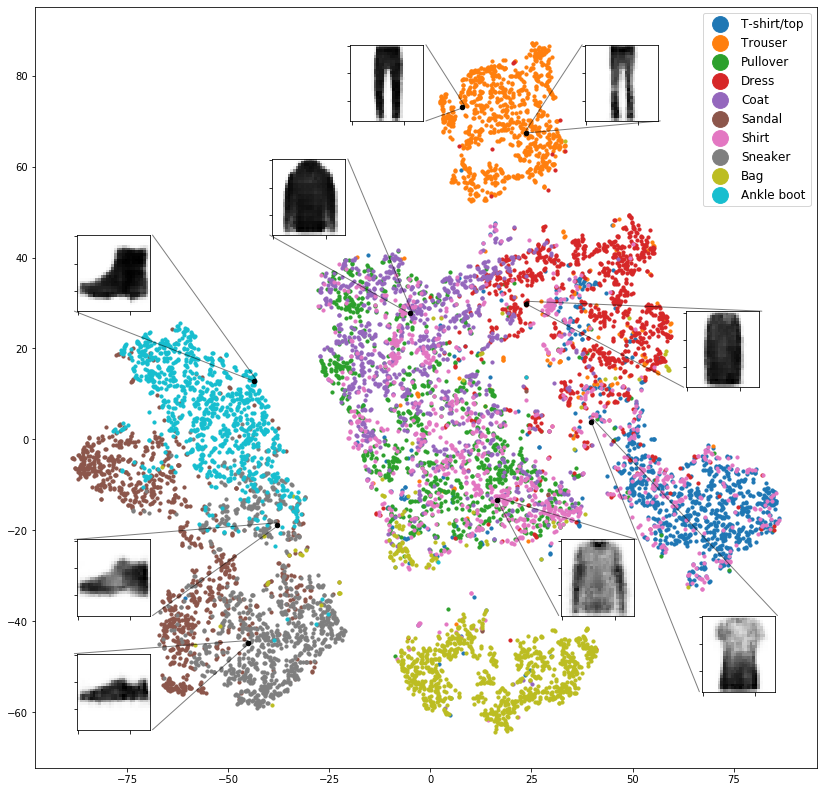

In [606]:
encoded_TSNE_loaded = np.load('TSNE_embedded_encoded_FMNIST.npy')
fig,ax = plt.subplots(figsize=[14,14])
decoded_samples = []
sample_idxs = [23,2,3,9,14,29,110,83,120]
for idx in sample_idxs:
    image = test_dataset[idx][0]
    encoded_sample = EncoderNet(image.unsqueeze(0))
    decoded_sample = DecoderNet(encoded_sample)
    decoded_samples.append(decoded_sample)

for i in range(10):
    mask = labels == i 
    ax.scatter(encoded_TSNE[mask,0],encoded_TSNE[mask,1],s=10,label=classes[i])
    
ax.legend(fontsize=12,markerscale=5)

ax.scatter(encoded_TSNE[sample_idxs,0],encoded_TSNE[sample_idxs,1],s = 20 ,c ='black')
coordsx,coordsy, thick  = [0.05 , 0.4 , 0.7 , 0.05 , 0.3 , 0.83 ,0.67, 0.05,0.85 ], [0.2,0.85,0.85,0.05,0.7,0.5,0.2,0.6,0.1],[0.1]*9
ax_inlets = [ax.inset_axes([crdsx,crdsy,thik,thik]) for crdsx,crdsy,thik in zip(coordsx,coordsy, thick)]
ax_zooms  = [ax.inset_axes([crdsx,crdsy,thik,thik]) for crdsx,crdsy,thik in zip(coordsx,coordsy, thick)]
for i,idx, ax_inlet,ax_zoom in zip(range(9),sample_idxs,ax_inlets,ax_zooms):
    x1, y1 = encoded_TSNE[idx]
    ax_zoom.set_xlim(x1, x1+0.5)
    ax_zoom.set_ylim(y1, y1+0.5)
    ax_zoom.axis('off')
    ax.indicate_inset_zoom(ax_zoom, edgecolor="black")
    ax_inlet.imshow(decoded_samples[i][0,0,:,:].detach(),cmap='Greys')
    ax_inlet.set_xticklabels([])
    ax_inlet.set_yticklabels([])
plt.show()

## Attempt to characterize the Latent variables
### Mean of each class

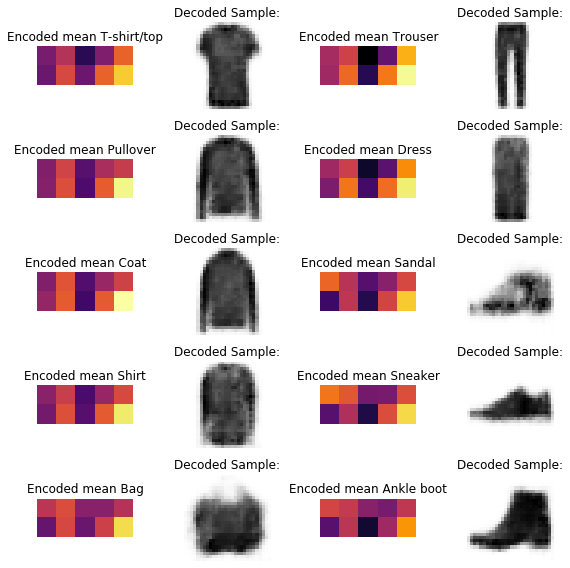

In [636]:
plt.figure(figsize=[8,8])
EncoderNet.eval()
DecoderNet.eval()
mean_objects = []
with torch.no_grad():
    for i in range(10):
        idxs = np.argwhere(labels == i).squeeze(0)
        encoded_images = []
        for idx in idxs:
            image = test_dataset[idx][0]
            encoded_images.append(EncoderNet(image.unsqueeze(0)))
        encoded_images = torch.cat(encoded_images)
        mean_image = torch.mean(encoded_images,axis=0)
        mean_objects.append(mean_image)




        plt.subplot(5,4,i*2+1)
        plt.title('Encoded mean '+classes[i])
        plt.imshow(mean_image.detach().numpy().reshape(2,5) , cmap='inferno',vmin = -80,vmax=+80)
        plt.axis('off')

        plt.subplot(5,4,i*2+2)
        plt.title('Decoded Sample:' )
        plt.imshow(DecoderNet(mean_image.unsqueeze(0)).squeeze(0).squeeze(0).detach().numpy(),cmap='Greys')
        plt.axis('off')
        
plt.tight_layout()
plt.show()

### Randomly generated samples

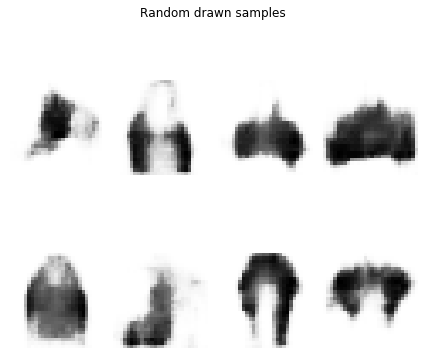

In [660]:
mean_tot = torch.mean(encoded_test,axis=0)
std_tot  = torch.std(encoded_test,axis=0) 
plt.figure(figsize=[6,6])
for i in range(8):
    latent_space = torch.normal(mean_tot,std_tot)
    plt.subplot(2,4,i+1)
    plt.imshow(DecoderNet(latent_space.unsqueeze(0)).squeeze(0).squeeze(0).detach().numpy(),cmap='Greys')
    plt.axis('off')
plt.tight_layout()
plt.suptitle('Random drawn samples')
plt.show()

### Linear combination of samples

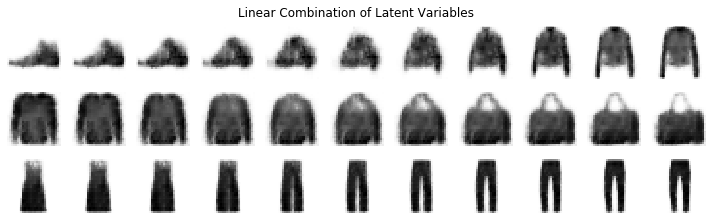

In [30]:
tot_combos  = 11
idxs = ([0,10],[20,30],[450,2])
EncoderNet.eval()
DecoderNet.eval()
plt.figure(figsize=[10,3])

with torch.no_grad():
    
    for i,idx in enumerate(idxs):
        sample1 , sample2 = test_dataset[idx[0]][0],test_dataset[idx[1]][0]
        enc1 = EncoderNet(sample1.unsqueeze(0))
        enc2 = EncoderNet(sample2.unsqueeze(0))

        ps = np.linspace(0,1,tot_combos)
        for j,p in enumerate(ps):

            lincombo = enc2*p + enc1*(1-p)
            plt.subplot(3,tot_combos,j+1+i*tot_combos)
            decod_image = DecoderNet(lincombo).squeeze(0).squeeze(0).detach()
            plt.imshow(decod_image,cmap='Greys')
            # if i==0:
            #     plt.title(f'{100-int(p*100)}% \n {int(p*100)} % ')
            plt.axis('off')
plt.suptitle('Linear Combination of Latent Variables',y=1.02)
plt.tight_layout()
plt.show()

# Variational Autoencoder

torch.Size([1, 10])

In [25]:
class VariationalEncoder(nn.Module):
    
    def __init__(self, InputShape, CH1 , Ksize1 , CH2 , Ksize2 , CH3 , Ksize3,
                 FCL,  encoded_space_dim,pDropout=0.0, init_func=init_weights):
        super().__init__()
        
        ### Convolutional section
        self.EncoderCNN = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(in_channels=1, out_channels=CH1, kernel_size=Ksize1, 
                      stride=2, padding=1),
            torch.nn.Dropout(pDropout),
            nn.ReLU(True),
            # Second convolutional layer
            nn.Conv2d(in_channels=CH1, out_channels=CH2, kernel_size=Ksize2, 
                      stride=2, padding=1),
            torch.nn.Dropout(pDropout),
            nn.ReLU(True),
            # Third convolutional layer
            nn.Conv2d(in_channels=CH2, out_channels=CH3, kernel_size=Ksize3, 
                      stride=2, padding=0),
            torch.nn.Dropout(pDropout),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
        
        # Ugly hack to calculate the shape of the output of the convolutional layer
        dummy_sample_image = torch.zeros(InputShape)
        self.FinalConvShape = self.EncoderCNN(dummy_sample_image).shape
        self.FlatConvSize  = np.prod(self.FinalConvShape)

        ### Linear section
        self.EncoderLin = nn.Sequential(
            # First linear layer
            nn.Linear(in_features=self.FlatConvSize, out_features=FCL),
            torch.nn.Dropout(pDropout),
            nn.ReLU(True),
        )
        
        # Final Layers
        self.Encodermu  = nn.Linear(in_features=FCL, out_features=encoded_space_dim)
        self.Encoderstd = nn.Linear(in_features=FCL, out_features=encoded_space_dim)

        
        self.EncoderCNN.apply(init_func)
        self.EncoderLin.apply(init_func)
        self.Encodermu.apply(init_func)
        self.Encoderstd.apply(init_func)
        
        self.N = torch.distributions.Normal(0, 1)
        self.kl = 0

        
    def forward(self, x):
        # Apply convolutions
        x = self.EncoderCNN(x)
        # Flatten
        x = self.flatten(x)
        # # Apply linear layers
        x = self.EncoderLin(x)
        
        mu  = self.Encodermu(x)
        std = torch.exp(self.Encoderstd(x))
        
        z = mu + std * self.N.sample(mu.shape)
        self.kl = (std.pow(2) + mu.pow(2) - torch.log(std) - 0.5).sum()
        
        
        
        return z if self.training else mu

In [26]:
# class FinalLoss():
    
#     def __init__(self,rec_loss,Net,lKL = 0):
#         self.rec_loss = rec_loss
#         self.Net = Net
#         self.lKL = lKL
#     def __call__(self,out, label_batch):
#         return self.rec_loss(out,label_batch) + self.lKL*self.Net.kl

In [64]:
batch_size = 512
train_dataset.dataset.transform = train_transforms
train_dataloader = DataLoader(train_dataset , batch_size=int(batch_size)  , shuffle=True  , num_workers=0)
val_dataloader   = DataLoader(val_dataset   , batch_size=len(val_dataset) , shuffle=False , num_workers=0)

encoded_dim = 10

FCL = 128

varencoder = VariationalEncoder(InputShape,CH1,Ksize1,CH2,Ksize2,CH3,Ksize3,FCL,encoded_dim,0.3)
FinalConvShape = varencoder.FinalConvShape[1:]
decoder    = Decoder(FinalConvShape,CH1,Ksize1,CH2,Ksize2,CH3,Ksize3,FCL,encoded_dim,0.3)

params_to_optimize = [
    {'params': varencoder.parameters()},
    {'params': decoder.parameters()}
]


optimizer = optim.Adam(params_to_optimize, lr=1e-3,weight_decay = 1e-4)
loss_fn = nn.MSELoss()

train_losses, val_losses = train_func(varencoder,decoder, train_dataloader , val_dataloader,
                                     device, loss_fn, optimizer, verbose = 0, kl = 5e-3/batch_size,
                                      num_epochs  = 10)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [05:06<00:00, 30.64s/it]


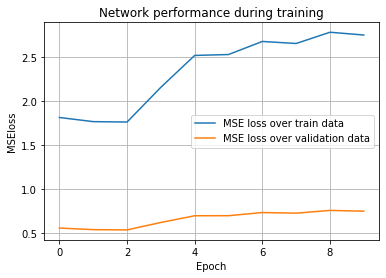

In [62]:
plt.plot(train_losses, label = 'MSE loss over train data')
plt.plot(val_losses, label = 'MSE loss over validation data')
plt.xlabel('Epoch')
plt.ylabel('MSEloss')
plt.title('Network performance during training')
plt.legend()
plt.grid()
plt.show()

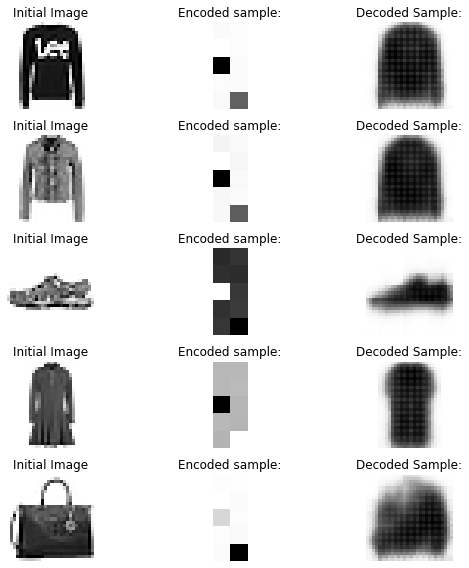

In [63]:
sample_idxs = [1,10,21,29,30]
plt.figure(figsize=[8,8])
n  = len(sample_idxs)

varencoder.eval()
decoder.eval()
with torch.no_grad():
    for i,idx in enumerate(sample_idxs):

        image = test_dataset[idx][0]
        encoded_sample = varencoder(image.unsqueeze(0))

        plt.subplot(n,3,1+ i*3)
        plt.title('Initial Image')
        plt.imshow(image.squeeze(0) , cmap='Greys')
        plt.axis('off')

        plt.subplot(n,3,2+i*3)
        plt.title(f'Encoded sample:')
        plt.imshow(encoded_sample.detach().numpy().reshape(5,2) , cmap='Greys')#,vmin = -34,vmax=+34)
        plt.axis('off')

        plt.subplot(n,3,3+i*3)
        plt.title('Decoded Sample:' )
        plt.imshow(decoder(encoded_sample).squeeze(0).squeeze(0).detach().numpy(),cmap='Greys')
        plt.axis('off')
plt.tight_layout()
plt.show()

In [39]:
varencoder(image.unsqueeze(0))

tensor([[-0.0064, -0.0152,  0.4076, -0.0232]], grad_fn=<AddmmBackward>)

In [53]:
loss_fn(decoder(varencoder(next(iter(train_dataloader))[0])),next(iter(train_dataloader))[0])

tensor(0.1469, grad_fn=<AddBackward0>)

In [54]:
images = torch.cat(images)
torch.mean(images,axis=0),torch.std(images,axis=0)

NameError: name 'images' is not defined

In [55]:
varencoder.training

False